In [20]:
import numpy as np
import pandas as pd
import os
import fnmatch
from Bio import SeqIO
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import ijson
from tqdm import tqdm

from scipy import stats
def fdr(p_vals):
    ranked_p_values = stats.rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1
    return fdr

# Fig 5a, c

In [2]:
KEGG_definition_file = '/home/zeyang.shen/lab_data/databases/ko_list'
KEGG_definition_df = pd.read_csv(KEGG_definition_file, sep='\t', index_col=0)

In [5]:
reference_path = '/home/zeyang.shen/lab_data/personal/Zeyang/Vitality/GWAS/reference/'
reference_files = fnmatch.filter(os.listdir(reference_path), '*.fna')
reference_dct = {}
for rf in reference_files:
    for seq_record in SeqIO.parse(reference_path+rf, 'fasta'):
        species_name = '_'.join(seq_record.description.split(' ')[1:3])
        reference_dct[species_name] = rf
        break
reference_dct

{'Micrococcus_luteus': 'GCF_900475555.1_44257_B01_genomic.fna',
 'Dermacoccus_nishinomiyaensis': 'GCF_000725405.1_ASM72540v1_genomic.fna',
 'Porphyromonas_pasteri': 'GCF_014647755.1_ASM1464775v1_genomic.fna',
 'Rothia_mucilaginosa': 'GCF_000175615.1_ASM17561v1_genomic.fna',
 'Lactococcus_lactis': 'GCF_003176835.1_ASM317683v1_genomic.fna',
 'Streptococcus_pneumoniae': 'GCF_001457635.1_NCTC7465_genomic.fna',
 'Cutibacterium_acnes': 'GCF_006739385.1_ASM673938v1_genomic.fna',
 'Staphylococcus_aureus': 'GCF_000013425.1_ASM1342v1_genomic.fna',
 'Streptococcus_thermophilus': 'GCF_903886475.1_Streptococcus_thermophilus_CIRM_65_genomic.fna',
 'Staphylococcus_epidermidis': 'GCF_006094375.1_ASM609437v1_genomic.fna',
 'Streptococcus_mitis': 'GCF_001281025.1_ASM128102v1_genomic.fna',
 'Gordonia_jacobaea': 'GCF_001186365.1_ASM118636v1_genomic.fna',
 'Streptococcus_sanguinis': 'GCF_900475505.1_42925_G01_genomic.fna',
 'Capnocytophaga_sputigena': 'GCF_002302495.1_ASM230249v1_genomic.fna',
 'Corynebact

test.Lactococcus_lactis.lvl2 gwas_output.variant.tsv (572161, 6) 6.646897422032013e-64
ADonly_Ac 5 4
ADonly_Ch 4 4
scorad_Ac 6 3
scorad_Ch 8 3
scoradflare_Ac 6 5
test.Staphylococcus_aureus.lvl2 gwas_output.variant.tsv (700108, 6) 6.6271738337787e-08
scorad_Ch 1 1
test.Staphylococcus_epidermidis.lvl2 gwas_output.variant.tsv (385917, 6) 6.934561486477332e-07
scorad_Ch 1 1
test.Streptococcus_thermophilus.lvl2 gwas_output.variant.tsv (724638, 6) 5.530581608245753e-08
scoradflare_Ac 3 1


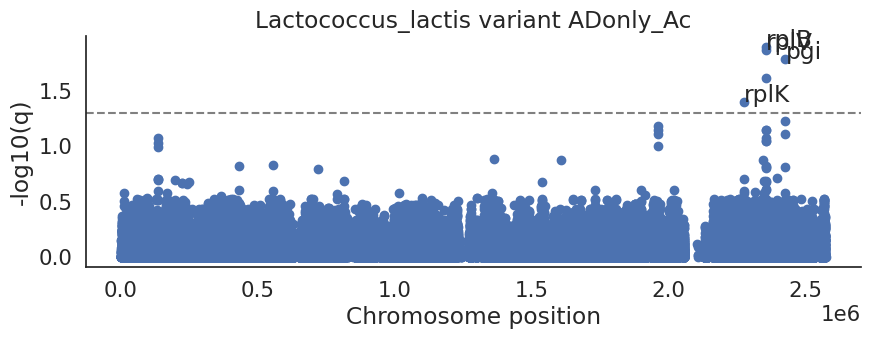

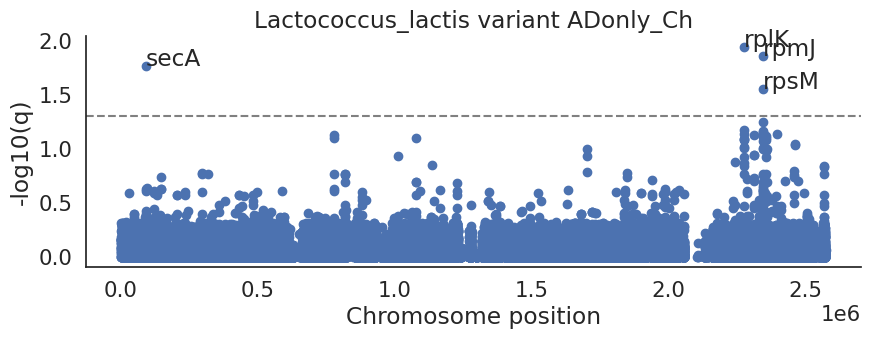

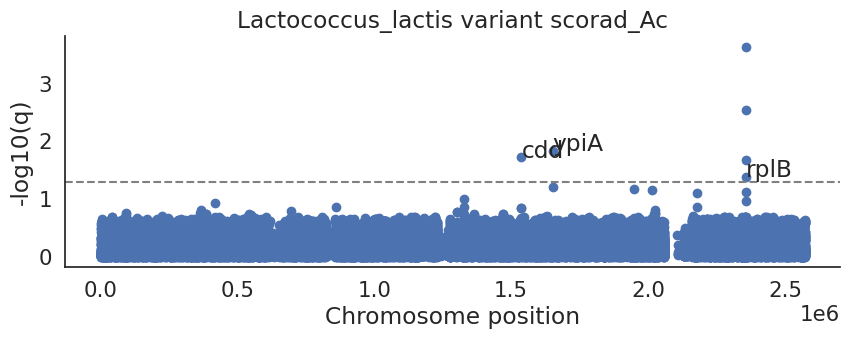

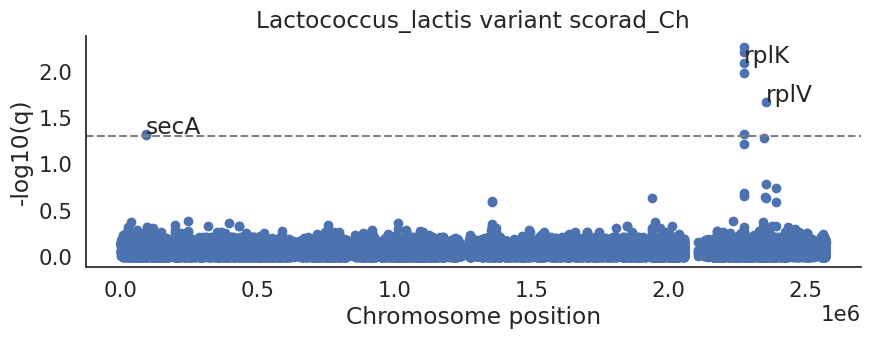

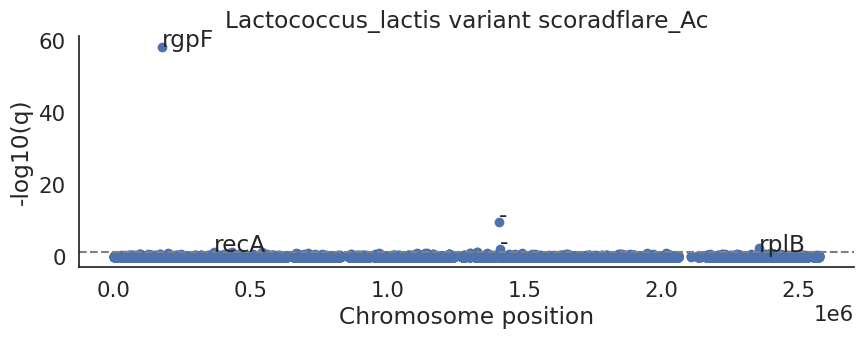

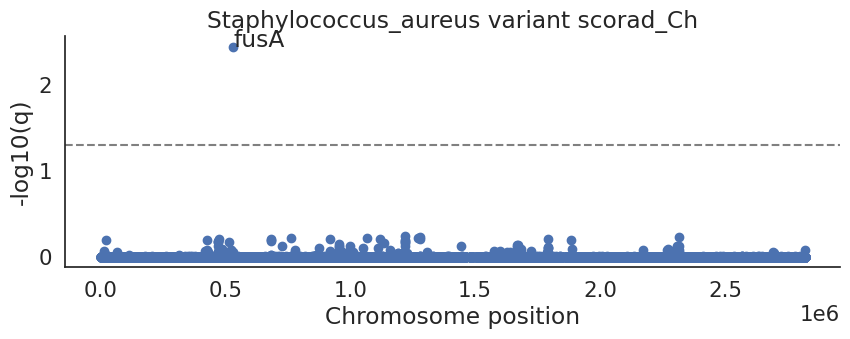

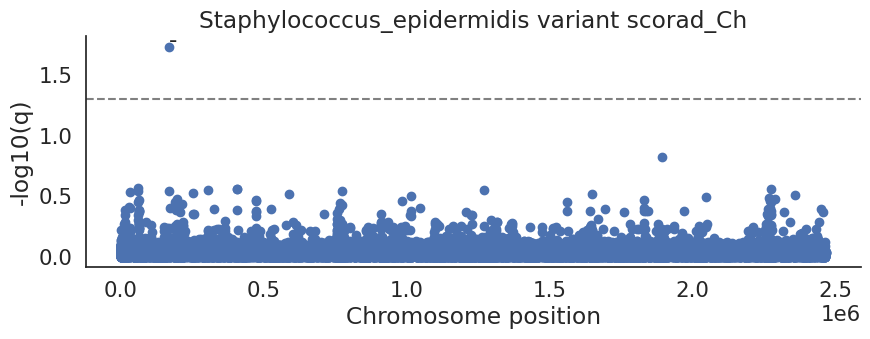

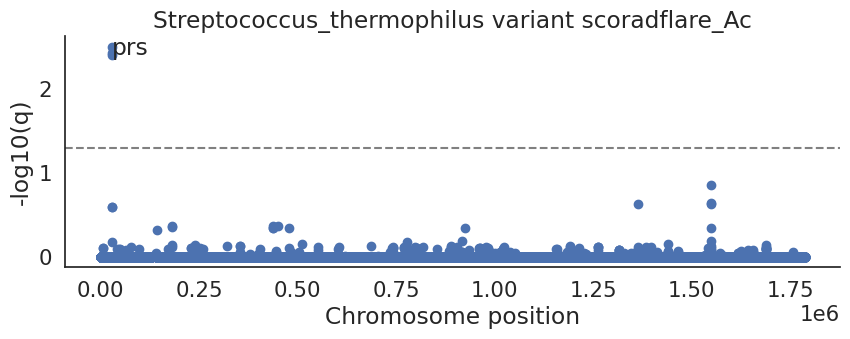

In [14]:
parent_dir = '/home/zeyang.shen/lab_data/personal/Zeyang/Vitality/GWAS/'
test_results_folders = sorted(fnmatch.filter(os.listdir(parent_dir), 'test.*lvl2'))
sig_df = pd.DataFrame()
sig_kegg_dct = {}
all_counts = 0
annotated_counts = 0
for folder in test_results_folders:
    species = folder.split('.')[1]
    egg_file = reference_path+'/'+reference_dct[species].replace('.fna','')+'.emapper.annotations'
    egg_df = pd.read_csv(egg_file, sep='\t', skiprows=4, index_col=0)
    egg_df = egg_df.iloc[:-3,]

    # Read test results
    test_result_files = fnmatch.filter(os.listdir(parent_dir+folder), 'gwas_output.variant*tsv')
    for test_result_file in test_result_files:
        mode = test_result_file.split('.')[1]
        test_result = pd.read_csv(parent_dir+folder+'/'+test_result_file, sep='\t')
        print(folder, test_result_file, test_result.shape, test_result['p'].min())
        for pheno in np.unique(test_result['Phenotype']):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cur_df = test_result.loc[test_result['Phenotype']==pheno]
                cur_df['species'] = species
                cur_df['mode'] = mode
                cur_df['Gene'] = [h.split('|')[-1] for h in cur_df['Hit']]
                analysis = '|'.join([species,mode,pheno])
                cur_df['analysis'] = analysis
                cur_df['q'] = fdr(cur_df['p'])
                cur_sig = cur_df.loc[cur_df['q']<0.05]
                if len(cur_sig) == 0:
                    continue
                direction_lst = []
                for row in cur_sig.iterrows():
                    if row[1]['Test'] == 'correlation':
                        if row[1]['Statistic'] > 0:
                            direction_lst.append('+')
                        else:
                            direction_lst.append('-')
                    elif row[1]['Test'] == 'enrichment':
                        if row[1]['Statistic'] > 1:
                            direction_lst.append('+')
                        else:
                            direction_lst.append('-')
                cur_sig['Direction'] = direction_lst
                for egg_col in ['KEGG_ko', 'Preferred_name']:
                    cur_sig[egg_col] = ['&'.join([egg_df.loc[h0,egg_col] if h0 in egg_df.index else "" for h0 in h.split('&')]) 
                                        for h in cur_sig['Gene']]
                sig_df = pd.concat([sig_df, cur_sig], axis=0)
                print(pheno, len(np.unique(cur_sig['Hit'])), len(np.unique(cur_sig['Gene'])))

                cur_df['Position'] = [int(h.split('|')[0].split(':')[-1]) for h in cur_df['Hit']]
                q_df = cur_df[['Position','q','Gene']].groupby('Position').min()
                q_lst = [q_df.loc[i,'q'] if i in q_df.index else np.nan for i in np.arange(q_df.index.max())]
                sns.set(style='white', font_scale=1.4)
                plt.figure(figsize=(10,3))
                plt.scatter(np.arange(q_df.index.max()), -np.log10(q_lst))
                plt.axhline(-np.log10(0.05), linestyle='--', color='grey')
                plt.xlabel('Chromosome position')
                plt.ylabel('-log10(q)')
                plt.title(' '.join([species, mode, pheno]))
                cur_sig['Position'] = [int(h.split('|')[0].split(':')[-1]) for h in cur_sig['Hit']]
                for row in cur_sig.drop_duplicates('Gene').iterrows():
                    plt.text(row[1]['Position'], -np.log10(row[1]['q']), row[1]['Preferred_name'])
                sns.despine(top=True)
                                
                # KEGG category
                cur_annot_df = egg_df.loc[[h0 for h in cur_df['Gene'] for h0 in h.split('&') if h0 in egg_df.index]]
                cur_sig_annot_df = egg_df.loc[[h0 for h in cur_sig['Gene'] for h0 in h.split('&') if h0 in egg_df.index]]
                sig_kegg = [j.replace('ko:','') for i in cur_sig_annot_df['KEGG_ko'] 
                            for j in i.split(',') if j!='-']
                sig_kegg_dct[analysis] = sig_kegg

# Fig 5b, d

/tmp/ipykernel_950921/3778089607.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_result_df['q'] = fdr(target_result_df['p'])
/tmp/ipykernel_950921/3778089607.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_result_sig[egg_col] = ['&'.join([egg_df.loc[h0,egg_col] if h0 in egg_df.index else "" for h0 in h.split('&')])
/tmp/ipykernel_950921/3778089607.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,Phenotype,Hit,Test,Statistic,p,q,species,mode,Gene,analysis,Direction,KEGG_ko,Preferred_name
473375,scorad_Ac,NZ_CP028160.1:2356588|LL14B4_RS11725,correlation,0.400597,4.976056e-09,0.000231,Lactococcus_lactis,variant,LL14B4_RS11725,Lactococcus_lactis|variant|scorad_Ac,+,ko:K02886,rplB
443908,scorad_Ac,NZ_CP028160.1:2356590|LL14B4_RS11725,correlation,0.303452,1.234136e-07,0.002866,Lactococcus_lactis,variant,LL14B4_RS11725,Lactococcus_lactis|variant|scorad_Ac,+,ko:K02886,rplB
458307,scorad_Ac,NZ_CP028160.1:1651826|LL14B4_RS08095,correlation,-0.547484,9.355793e-07,0.014482,Lactococcus_lactis,variant,LL14B4_RS08095,Lactococcus_lactis|variant|scorad_Ac,-,-,ypiA
447906,scorad_Ac,NZ_CP028160.1:1537238|LL14B4_RS07625,correlation,-0.357858,2.054408e-06,0.019081,Lactococcus_lactis,variant,LL14B4_RS07625,Lactococcus_lactis|variant|scorad_Ac,-,ko:K01489,cdd
473410,scorad_Ac,NZ_CP028160.1:2356578|LL14B4_RS11725,correlation,0.276834,1.831604e-06,0.021264,Lactococcus_lactis,variant,LL14B4_RS11725,Lactococcus_lactis|variant|scorad_Ac,+,ko:K02886,rplB
437947,scorad_Ac,NZ_CP028160.1:2356558|LL14B4_RS11725,correlation,0.303285,5.377860e-06,0.041624,Lactococcus_lactis,variant,LL14B4_RS11725,Lactococcus_lactis|variant|scorad_Ac,+,ko:K02886,rplB


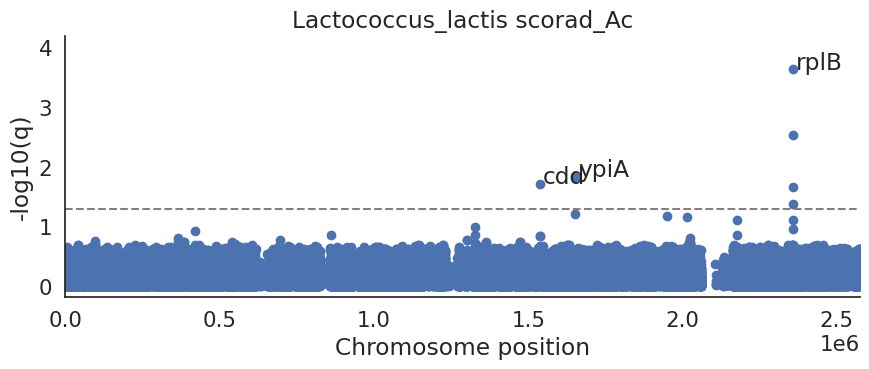

In [15]:
target_species = 'Lactococcus_lactis'
target_phenotype = 'scorad_Ac'
egg_file = reference_path+'/'+reference_dct[target_species].replace('.fna','')+'.emapper.annotations'
egg_df = pd.read_csv(egg_file, sep='\t', skiprows=4, index_col=0)
egg_df = egg_df.iloc[:-3,]
test_result = pd.read_csv(parent_dir+'test.'+target_species+'.lvl2/gwas_output.variant.tsv', sep='\t')
test_result['Gene'] = [h.split('|')[-1] for h in test_result['Hit']]
target_result_df = test_result.loc[test_result['Phenotype']==target_phenotype]
target_result_df['q'] = fdr(target_result_df['p'])
target_result_sig = target_result_df.loc[target_result_df['q']<0.05]
for egg_col in ['KEGG_ko', 'Preferred_name']:
    target_result_sig[egg_col] = ['&'.join([egg_df.loc[h0,egg_col] if h0 in egg_df.index else "" for h0 in h.split('&')]) 
                                  for h in target_result_sig['Gene']]
target_result_df['Position'] = [int(h.split('|')[0].split(':')[-1]) for h in target_result_df['Hit']]
q_df = target_result_df[['Position','q','Gene']].groupby('Position').min()
q_lst = -np.log10([q_df.loc[i,'q'] if i in q_df.index else np.nan for i in np.arange(q_df.index.max())])
sns.set(style='white', font_scale=1.4)
plt.figure(figsize=(9,4))
plt.scatter(np.arange(q_df.index.max()), q_lst)
plt.axhline(-np.log10(0.05), linestyle='--', color='grey')
plt.xlabel('Chromosome position')
plt.ylabel('-log10(q)')
plt.title(' '.join([target_species, target_phenotype]))
plt.xlim(0,q_df.index.max()+1)
ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax * 1.1)
target_result_sig['Position'] = [int(h.split('|')[0].split(':')[-1]) for h in target_result_sig['Hit']]
for row in target_result_sig.sort_values('q').drop_duplicates('Gene').iterrows():
    plt.text(row[1]['Position']+1e4, -np.log10(row[1]['q']), row[1]['Preferred_name'])
sns.despine(top=True)
plt.tight_layout()
plt.savefig('../figs/AD_MGWAS_manhattan'+target_species+'_'+target_phenotype+'.png', format='png', dpi=300)

target_keggs = ['K01810']
# target_keggs = ['K01803','K00873'] #L. lactis - glycolysis
# target_keggs = ['K01695','K01696','K01817','K01609','K00766','K13497','K01658','K01657'] #S. mitis - tryptophan
sig_df.loc[np.all([sig_df['mode']=='variant', 
                   sig_df['Phenotype']==target_phenotype, 
                   # [np.any([k0 in target_keggs for k0 in k.replace('ko:','').split(',')]) for k in sig_df['KEGG_ko']],
                   sig_df['species']==target_species], axis=0)].sort_values('q')

In [21]:
target_hit = "NZ_CP028160.1:1651826"
json_file = os.path.join(parent_dir, 'Variants.filteredlvl2.'+target_species+'.json')
with open(json_file, "r") as f:
    parser = ijson.kvitems(f, "")
    for variant, values in tqdm(parser, unit="variants"):
        v = variant.rstrip().split('|')[0]
        if v == target_hit:
            print(variant)
            break

187726variants [04:37, 676.65variants/s]

NZ_CP028160.1:1651826|


In [22]:
geno_pheno_lst = []
for sample in values:
    try:
        geno_pheno_lst.append((sample, values[sample], pheno_dct[target_phenotype][sample]))
    except:
        continue
geno_pheno_df = pd.DataFrame(geno_pheno_lst)
geno_pheno_df.columns = ['sample', 'genotype', 'phenotype']
geno_pheno_df = geno_pheno_df.loc[geno_pheno_df['genotype']!=-1]
geno_pheno_df = geno_pheno_df.loc[geno_pheno_df['phenotype'].notnull()]
geno_pheno_df['genotype'] = geno_pheno_df['genotype']>0
if len(set(geno_pheno_df['phenotype']))==2:
    geno_pheno_df['phenotype'] = geno_pheno_df['phenotype'].map({'T': 1, 'F': 0})
print('Genotype:', Counter(geno_pheno_df['genotype']))
print('Phenotype:', Counter(geno_pheno_df['phenotype']))
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(5,5))
tab10_colors = plt.get_cmap("tab10").colors
selected_colors = [tab10_colors[i] for i in [0, 3]]
sns.set_palette(selected_colors)
if len(set(geno_pheno_df['phenotype']))==2:
    ax = sns.violinplot(data=geno_pheno_df, x='genotype', y='phenotype')
else:
    ax = sns.boxplot(data=geno_pheno_df, x='genotype', y='phenotype', boxprops={'alpha': 0.4})
    sns.stripplot(data=geno_pheno_df, x='genotype', y='phenotype', ax=ax)
plt.title(target_hit+' ('+list(sig_df.loc[[target_hit in h for h in sig_df['Hit']], 'Preferred_name'])[0]+')')
sns.despine(top=True)
plt.tight_layout()
# plt.savefig('../figs/AD_MGWAS_'+'_'.join([target_species, target_phenotype, target_hit.replace(':','_')])+'.png', format='png', dpi=300)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements